In [56]:
#import pyarrow.feather as feather
import pandas as pd
import numpy as np
#from scipy.io import netcdf
import matplotlib.pyplot as plt 
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(color_codes=True)


In [2]:
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
# it is better for visualisation if the columns date type (not int or str)
# when save df to csv, if the column names are date, they are saved as str
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        try:
            new_columns.append(pd.to_datetime(col).date())
        except: new_columns.append(col)
    return new_columns

In [8]:
###########################################################################################################

In [4]:
# import sample6
grouped_t_s= pd.read_csv(f"dataset/modeling/sample6/ts.csv").set_index("proj_id")
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
ave_temp= pd.read_csv(f"dataset/modeling/sample6/temp.csv").set_index("proj_id")
ave_temp.columns = convert_col_to_date(ave_temp.columns)
cum_prec= pd.read_csv(f"dataset/modeling/sample6/prec.csv").set_index("proj_id")
cum_prec.columns = convert_col_to_date(cum_prec.columns)
print(grouped_t_s.shape)
print(ave_temp.shape)
print(cum_prec.shape)

(9, 6546)
(9, 6546)
(9, 6546)


# func

In [5]:
# create df for a t s (one row in grouped_t_s df)
def create_one_ts_df(row):
    bgr = row.name
    idx = row.dropna().index[2:]
    ts = row[idx]
    temp = ave_temp[idx].loc[bgr]
    prec = cum_prec[idx].loc[bgr]
    df = pd.DataFrame({"ts":ts,"temp": temp,"prec":prec, })
    return df


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def split_df(reframed):
    # split into train and test sets, 
    values = reframed.values
    n_train = int(len(reframed)*0.8)
    train = values[:n_train, :]
    test = values[n_train:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, train_y, test_X, test_y


# pick t s

ts length:4240.0, freq: 1.0
(4240, 3)


Text(0.5, 1.0, 'prec')

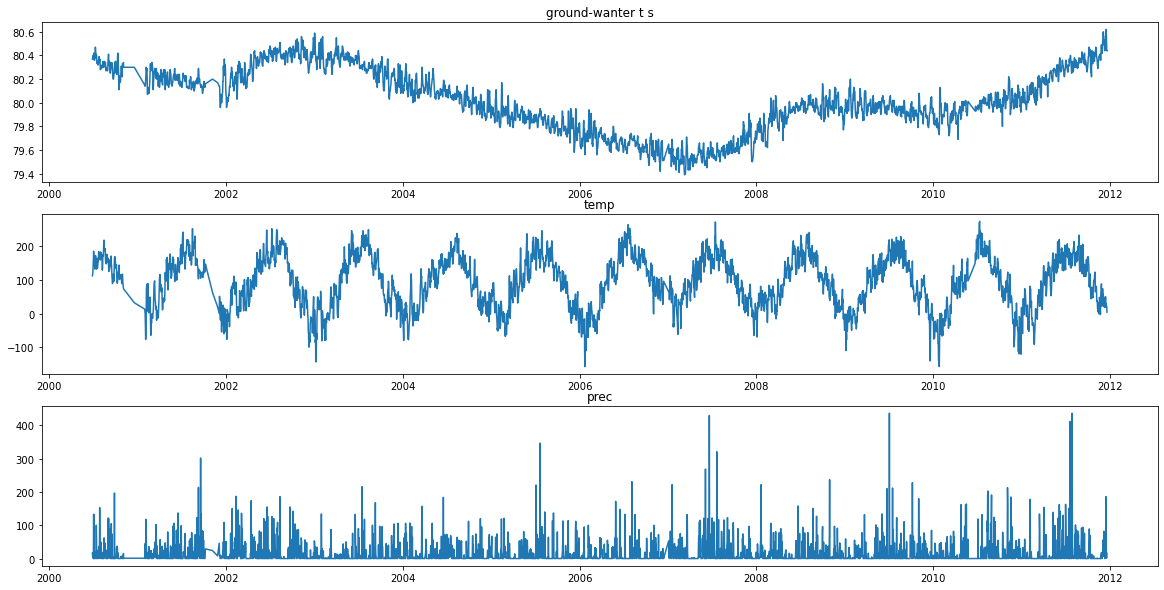

In [24]:
# apply the func
ts1 = grouped_t_s.iloc[3]
print(f"ts length:{ts1[0]}, freq: {ts1[1]}")
df = create_one_ts_df(ts1)
print(df.shape)
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 0,4000
axs[0].plot(df["ts"][a:b])
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["prec"][a:b])
axs[2].set_title('prec')

In [25]:
df

,ts,temp,prec
2000-06-28,80.37,112.0,17.0
2000-06-29,80.37,116.0,7.0
2000-06-30,80.39,126.0,15.0
2000-07-01,80.40,143.0,2.0
2000-07-02,80.37,157.0,0.0
...,...,...,...
2012-08-12,80.56,152.0,0.0
2012-08-13,80.57,158.0,0.0
2012-08-14,80.58,158.0,0.0
2012-08-15,80.58,166.0,0.0


# apply

In [26]:
# convert the df to match lstm data
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[-2:], axis=1, inplace=True)
print(reframed.shape)
reframed.index= df.index[1:]
reframed.head()

(4239, 4)


,var1(t-1),var2(t-1),var3(t-1),var1(t)
2000-06-29,0.742428,0.629291,0.038902,0.742428
2000-06-30,0.742428,0.638444,0.016018,0.757576
2000-07-01,0.757576,0.661327,0.034325,0.765156
2000-07-02,0.765156,0.700229,0.004577,0.742428
2000-07-03,0.742428,0.732265,0.000000,0.750000


In [87]:
################################################################
# split the data
train_X, train_y, test_X, test_y= split_df(reframed)
print("input to be 3D [samples, timesteps(lag, features]\n")
print(f"train: {train_X.shape} , {train_y.shape} ,test: {test_X.shape} , {test_y.shape}")
####################################################################

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
##############################################################################


input to be 3D [samples, timesteps(lag, features]

train: (3391, 1, 3) , (3391,) ,test: (848, 1, 3) , (848,)
Epoch 1/50
48/48 - 2s - loss: 0.2988 - val_loss: 0.3244
Epoch 2/50
48/48 - 0s - loss: 0.1721 - val_loss: 0.2066
Epoch 3/50
48/48 - 0s - loss: 0.1448 - val_loss: 0.1888
Epoch 4/50
48/48 - 0s - loss: 0.1342 - val_loss: 0.1753
Epoch 5/50
48/48 - 0s - loss: 0.1247 - val_loss: 0.1610
Epoch 6/50
48/48 - 0s - loss: 0.1143 - val_loss: 0.1477
Epoch 7/50
48/48 - 0s - loss: 0.1044 - val_loss: 0.1324
Epoch 8/50
48/48 - 0s - loss: 0.0939 - val_loss: 0.1181
Epoch 9/50
48/48 - 0s - loss: 0.0809 - val_loss: 0.1005
Epoch 10/50
48/48 - 0s - loss: 0.0671 - val_loss: 0.0856
Epoch 11/50
48/48 - 0s - loss: 0.0575 - val_loss: 0.0789
Epoch 12/50
48/48 - 0s - loss: 0.0508 - val_loss: 0.0782
Epoch 13/50
48/48 - 0s - loss: 0.0467 - val_loss: 0.0744
Epoch 14/50
48/48 - 0s - loss: 0.0421 - val_loss: 0.0634
Epoch 15/50
48/48 - 0s - loss: 0.0370 - val_loss: 0.0572
Epoch 16/50
48/48 - 0s - loss: 0.0352 - val_l

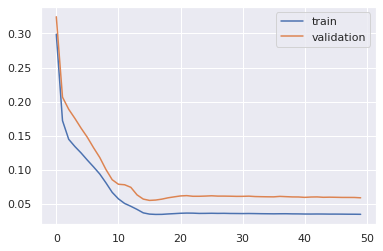

In [88]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


# for outliers

In [71]:
# make a prediction
train_y_pred = model.predict(train_X)
train_y = train_y.reshape(train_y_pred.shape[0],train_y_pred.shape[1])
scored = pd.DataFrame(index=reframed.index[:len(train_y)]) 
scored['Loss_mae'] = np.abs(train_y - train_y_pred)
scored

,Loss_mae
2000-06-29,0.067602
2000-06-30,0.083505
2000-07-01,0.077399
2000-07-02,0.049226
2000-07-03,0.077354
...,...
2010-03-20,0.056765
2010-03-21,0.023127
2010-03-22,0.038510
2010-03-23,0.028957


(0.0, 0.5)

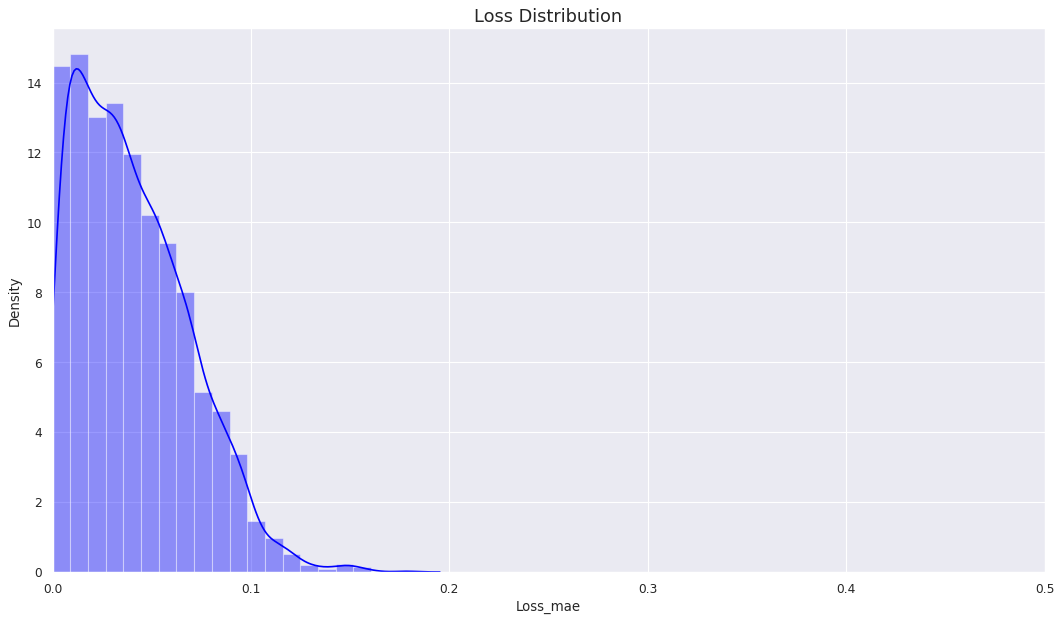

In [72]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [73]:
thre = np.mean(scored,axis=0)[0]+4*np.std(scored,axis=0)[0]
thre

0.1543789617717266

In [75]:
# make a prediction test
test_y_pred = model.predict(test_X)
test_y = test_y.reshape(test_y_pred.shape[0],test_y_pred.shape[1])
scored_test = pd.DataFrame(index=reframed.index[len(train_y):]) 
scored_test['Loss_mae'] = np.abs(test_y - test_y_pred)
scored_test

,Loss_mae
2010-03-25,0.046570
2010-03-26,0.060988
2010-03-27,0.048580
2010-03-28,0.014201
2010-03-29,0.024285
...,...
2012-08-12,0.099664
2012-08-13,0.093824
2012-08-14,0.094754
2012-08-15,0.088043


In [79]:
scored = pd.concat([scored,scored_test])
scored['Anomaly'] = scored['Loss_mae'] > thre
scored

,Loss_mae,Anomaly
2000-06-29,0.067602,False
2000-06-30,0.083505,False
2000-07-01,0.077399,False
2000-07-02,0.049226,False
2000-07-03,0.077354,False
...,...,...
2012-08-12,0.099664,False
2012-08-13,0.093824,False
2012-08-14,0.094754,False
2012-08-15,0.088043,False


In [80]:
print(scored[scored["Anomaly"]==True].shape)
scored[scored["Anomaly"]==True]

(18, 2)


,Loss_mae,Anomaly
2003-01-02,0.178439,True
2003-02-03,0.154990,True
2003-12-21,0.160590,True
2010-01-28,0.154755,True
2010-04-15,0.159937,True
2010-10-15,0.189723,True
2011-10-18,0.220364,True
2011-12-16,0.170916,True
2012-01-05,0.177373,True
2012-02-15,0.183185,True


In [81]:
anomaly = scored[scored["Anomaly"]==True].index
anomaly

Index([2003-01-02, 2003-02-03, 2003-12-21, 2010-01-28, 2010-04-15, 2010-10-15,
       2011-10-18, 2011-12-16, 2012-01-05, 2012-02-15, 2012-05-08, 2010-04-15,
       2010-10-15, 2011-10-18, 2011-12-16, 2012-01-05, 2012-02-15, 2012-05-08],
      dtype='object')

Text(0.5, 1.0, 'prec')

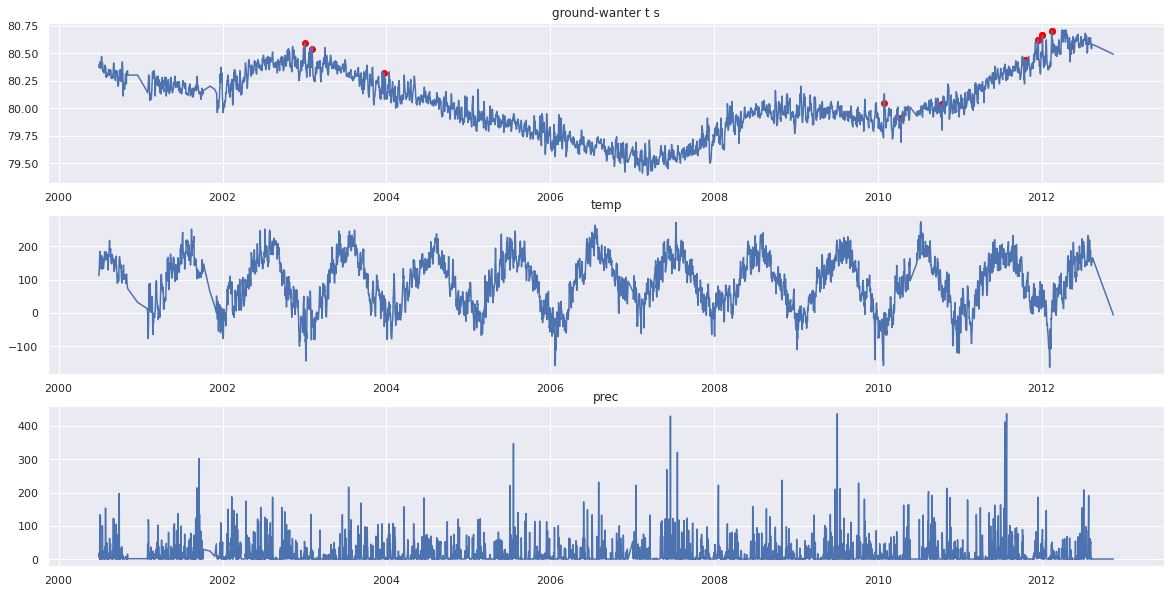

In [84]:
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 0,5000
#a,b = 220,320
axs[0].plot(df["ts"][a:b])
axs[0].scatter(anomaly[:], df["ts"][anomaly][:], color="red")
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["prec"][a:b])
axs[2].set_title('prec')

# for prediction

In [89]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = scaler.inverse_transform(np.concatenate((yhat, test_X[:, 1:]), axis=1))[:,0]
#inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = scaler.inverse_transform(np.concatenate((test_y, test_X[:, 1:]), axis=1))[:,0]
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
#####################################################################



Test RMSE: 0.090


In [104]:
print(f"std ts: {np.std(ts1.dropna())}")
print(f"std test_y: {np.std(inv_y)}")

std ts: 63.87580681926605
std test_y: 0.24004213511943817


<AxesSubplot:>

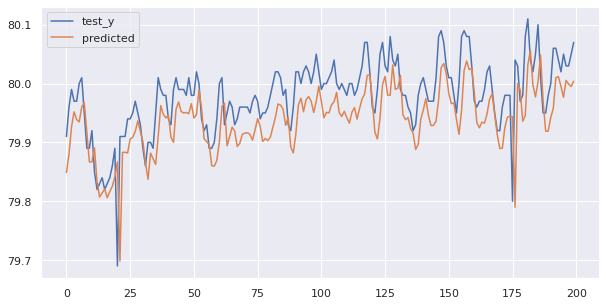

In [96]:
fd = pd.DataFrame([inv_y, inv_yhat]).T[:]
fd.columns = ["test_y", "predicted"]
fd.iloc[0:200].plot(figsize=(10,5))